Practical 1: Sentiment Detection of Movie Reviews
========================================



This practical concerns sentiment detection of movie reviews.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task (how might one go about classifying the texts?); you will write
code that decides whether a random unseen movie review is positive or
negative.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002). 
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. were the "inventors" of the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Bo Pang’s system. If you have questions about it,
we should resolve them in our first demonstrated practical.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.

**Environment**

All code should be written in **Python 3**. 
If you use Colab, check if you have that version with `Runtime -> Change runtime type` in the top menu.

> If you want to work in your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download). 
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects.

#### Learning Python 3

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

Loading the Data
-------------------------------------------------------------

In [ ]:
# download sentiment lexicon
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

In [1]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
#from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# load reviews into memory
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list} 
#  {"cv": integer, "sentiment": str, "content": list} 
#   ..
# ]
# where `content` is a list of sentences, 
# with a sentence being a list of (token, pos_tag) pairs.

# For documentation on POS-tags, see 
# https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf

with open("reviews.json", mode="r", encoding="utf-8") as f:
    reviews = json.load(f)
    
print(len(reviews))

def print_sentence_with_pos(s):
    print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
    print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
    print_sentence_with_pos(r["content"][0])
    if i == 4: 
        break
    
c = Counter()
for review in reviews:
    for sentence in review["content"]:
        for token, pos_tag in sentence:
            c[token.lower()] += 1

print("#types", len(c))

print("Most common tokens:")
for token, count in c.most_common(25):
    print("%10s : %8d" % (token, count))
  

2000
0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.
#types 47743
Most common tokens:
       

Symbolic approach – sentiment lexicon (2pts)
---------------------------------------------------------------------



**How** could one automatically classify movie reviews according to their
sentiment? 

If we had access to a **sentiment lexicon**, then there are ways to solve
the problem without using Machine Learning. One might simply look up
every open-class word in the lexicon, and compute a binary score
$S_{binary}$ by counting how many words match either a positive, or a
negative word entry in the sentiment lexicon $SLex$.

$$S_{binary}(w_1w_2...w_n) = \sum_{i = 1}^{n}\text{sgn}(SLex\big[w_i\big])$$

**Threshold.** In average there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1w_2...w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{else }
        \end{array}
$$

To implement this approach, you should use the sentiment
lexicon in `sent_lexicon`, which was taken from the
following work:

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.


#### (Q: 1.1) Implement this approach and report its classification accuracy. (1 pt)

##### This block loads the lexicon file and stores the sentiments and word types as dictionaries

In [3]:
#
# Given a line from the sentiment file 
# ex. type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
# Returns a dictionary 
# ex. {type: weaksubj, len: 1, word1: abandoned, pos1: adj, stemmed1: n, priorpolarity: negative}
#
def sentiment_line_to_dict(line):
    dictionary = {}
    
    words = line.split()
    for word in words:
        variable_assignment = word.split('=')
        variable = variable_assignment[0]
        value = variable_assignment[1]
        
        dictionary[variable] = value
    
    return dictionary

#
# Adds the word with the sentiment to the dictionary.
# If the word is already in the dictionary and the sentiments are conflicting, 
# the sentiment will be set to 0 (neutral).
#
def add_sentiment_to_dict(sentiment_dict, word, sentiment):
    if word in sentiment_dict.keys():
        if not sentiment_dict[word] == sentiment:
            sentiment_dict[word] = 0
    else:
         sentiment_dict[word] = sentiment
    
    return sentiment_dict

#
# Adds the word with the type to the dictionary.
# If the word is already in the dictionary and the types are conflicting, 
# the type will be set to 2 (neutral).
#
def add_type_to_dict(type_dict, word, word_type):
    if word in type_dict.keys():
        if not type_dict[word] == word_type:
            type_dict[word] = 2
    else:
         type_dict[word] = word_type
            
    return type_dict


#
# Converts a sentiment string: "positive", "negative", "neutral" to 1, -1 and 0 respectively.
#
def sentiment_to_score(sentiment_as_string):
    if sentiment_as_string == 'positive':
        return 1
    if sentiment_as_string == 'negative':
        return -1
    return 0


#
# Converts a type string: "strongsubj", "weaksubj" to 2, and 1 respectively.
#
def type_to_score(type_as_string):
    if type_as_string == 'strongsubj':
        return 3
    if type_as_string == 'weaksubj':
        return 1
    
    return 1
    
    
#
# Parses the lexicon file and return 2 dictionaries:
#  sentiment_dict with structure: { "love": 1, "hate": -1, "butter": 0 ... }
#    1 is positive, -1 is negative, 0 is neutral.
#
#  type_dict with structure:      { "love": 2, "hate": 1, "butter": 1.5 ... } 
#    2 is a strong type, 1 is a weak type and 1.5 is a word that had both types in the file.
#
def parse_lexicon_to_dicts():
    with open("sent_lexicon", mode="r", encoding="utf-8") as file:
        array_of_lines = file.readlines()
    
    sentiment_dict = {}
    type_dict = {}
    
    for line in array_of_lines:
        line_as_dict = sentiment_line_to_dict(line)
        
        word      = line_as_dict['word1']
        word_type = type_to_score(line_as_dict['type'])
        sentiment = sentiment_to_score(line_as_dict['priorpolarity'])
        
        sentiment_dict = add_sentiment_to_dict(sentiment_dict, word, sentiment)
        type_dict      = add_type_to_dict(type_dict, word, word_type)
        
    return sentiment_dict, type_dict


sentiment_dict, type_dict = parse_lexicon_to_dicts()    
print("Loaded the file!")


Loaded the file!


##### This block contains the binary classification code

In [4]:
THRESHOLD = 8


#
# Given a review returns a list of all the words.
# note: all words are converted to lowercase
#
def get_words_of_review(review):
    content = review['content']
    
    words = []
    for line in content:
        for word_pair in line:
            word = word_pair[0]
            word_in_lowercase = word.lower()
            words.append(word_in_lowercase)
            
    return words


#
# Returns the binary (unaltered) score of the word;
# 1 for positive, -1 for negative, 0 for neutral or not found.
#
def get_binary_score_of_word(word):
    try:
        return sentiment_dict[word]
    except KeyError:
        # Word not in our dictionary.
        return 0


#
# Given a review returns the real sentiment.
# -1 for negative, 1 for positive.
#
def get_real_sentiment_of_review(review):
    if (review['sentiment'] == 'NEG'):
        return -1
    
    return 1
 
    
#
# Given a review returns 1 if it classifies it as positive, and -1 otherwise.
#
def binary_classify_review(review):
    words = get_words_of_review(review)
    
    score = 0
    for word in words:
        score += get_binary_score_of_word(word)
    
    if score > THRESHOLD:
        return 1
    
    return -1
            

#
# Returns token_results which is a list of wheter our predictions were correct: ['-', '+', '-', ...]
# And returns the accuracy as a percentage, e.g. 45 for 45% accuracy.
#
def binary_classify_all_reviews():
    total = 0
    correct = 0
    token_results = []
    
    for review in reviews:
        prediction     = binary_classify_review(review)
        real_sentiment = get_real_sentiment_of_review(review)
        
        if prediction == real_sentiment:
            correct += 1
            token_results.append('+')
        else:
            token_results.append('-')
        
        total += 1
    
    accuracy = correct / total * 100
    return accuracy, token_results



In [5]:
binary_accuracy, binary_results = binary_classify_all_reviews()
print("Binary classification accuracy: {0:.2f}%".format(binary_accuracy))

Binary classification accuracy: 68.45%


If the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* would have higher magnitude than
*“good"*), we could take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Their lexicon also records two possible magnitudes of sentiment (*weak*
and *strong*), so you can implement both the binary and the weighted
solutions (please use a switch in your program). For the weighted
solution, you can choose the weights intuitively *once* before running
the experiment.

#### (Q: 1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1 pt)

In [6]:
#
# Returns the weighted score of the word;
# it multiplies the original score of the word with the type (strong 3, neutral 2, or weak 1).
#
def get_weighted_score_of_word(word):
    try:
        score = sentiment_dict[word]
        word_type = type_dict[word]
        return word_type * score
    
    except KeyError:
        # Word not in our dictionary.
        return 0

    
#
# Given a review returns 1 if it classifies it as positive, and -1 otherwise.
#
def weighted_classify_review(review):
    words = get_words_of_review(review)
    
    score = 0
    for word in words:
        score += get_weighted_score_of_word(word)
    
    if score > THRESHOLD:
        return 1
    
    return -1


#
# Returns token_results which is a list of wheter our predictions were correct: ['-', '+', '-', ...]
# And returns the accuracy as a percentage, e.g. 45 for 45% accuracy.
#
def weighted_classify_all_reviews():
    total = 0
    correct = 0
    token_results = []
    
    for review in reviews:
        prediction     = weighted_classify_review(review)
        real_sentiment = get_real_sentiment_of_review(review)
        
        if prediction == real_sentiment:
            correct += 1
            token_results.append('+')
        else:
            token_results.append('-')
        
        total += 1
    
    accuracy = correct / total * 100
    return accuracy, token_results



In [7]:
magnitude_accuracy, magnitude_results = weighted_classify_all_reviews()
print("Magnitude classification accuracy: {0:.2f}%".format(magnitude_accuracy))

Magnitude classification accuracy: 68.80%


#### Optional: make a barplot of the two results.

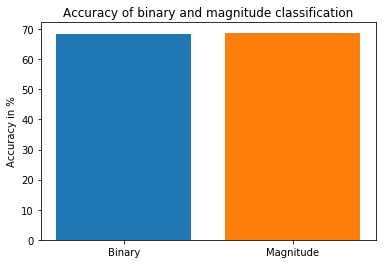

In [8]:

plt.bar("Binary", binary_accuracy)
plt.bar("Magnitude", magnitude_accuracy)
plt.ylabel("Accuracy in %")
plt.title("Accuracy of binary and magnitude classification")

plt.show()


Answering questions in statistically significant ways (1pt)
-------------------------------------------------------------

Does using the magnitude improve the results? Oftentimes, answering questions like this about the performance of
different signals and/or algorithms by simply looking at the output
numbers is not enough. When dealing with natural language or human
ratings, it’s safe to assume that there are infinitely many possible
instances that could be used for training and testing, of which the ones
we actually train and test on are a tiny sample. Thus, it is possible
that observed differences in the reported performance are really just
noise. 

There exist statistical methods which can be used to check for
consistency (*statistical significance*) in the results, and one of the
simplest such tests is the **sign test**. 

The sign test is based on the binomial distribution. Count all cases when System 1 is better than System 2, when System 2 is better than System 1, and when they are the same. Call these numbers $Plus$, $Minus$ and $Null$ respectively. 

The sign test returns the probability that the null hypothesis is true. 

This probability is called the $p$-value and it can be calculated for the two-sided sign test using the following formula (we multiply by two because this is a two-sided sign test and tests for the significance of differences in either direction):

$$2 \, \sum\limits_{i=0}^{k} \binom{N}{i} \, q^i \, (1-q)^{N-i}$$

where $$N = 2 \Big\lceil \frac{Null}{2}\Big\rceil + Plus + Minus$$ is the total
number of cases, and
$$k = \Big\lceil \frac{Null}{2}\Big\rceil + \min\{Plus,Minus\}$$ is the number of
cases with the less common sign. 

In this experiment, $q = 0.5$. Here, we
treat ties by adding half a point to either side, rounding up to the
nearest integer if necessary. 


#### (Q 2.1): Implement the sign test. Is the difference between the two symbolic systems significant? What is the p-value? (1 pt)

You should use the `comb` function from `scipy` and the `decimal` package for the stable adding of numbers in the final summation.

You can quickly verify the correctness of
your sign test code using a [free online
tool](https://www.graphpad.com/quickcalcs/binomial1.cfm).

In [9]:
from decimal import Decimal
from scipy.misc import comb


def sign_test(results_1, results_2):
    """test for significance
    results_1 is a list of classification results (+ for correct, - incorrect)
    results_2 is a list of classification results (+ for correct, - incorrect)
    """
    ties, plus, minus = 0, 0, 0

    # "-" carries the error
    for i in range(0, len(results_1)):
        if results_1[i]==results_2[i]:
            ties += 1
        elif results_1[i]=="-": 
            plus += 1
        elif results_2[i]=="-": 
            minus += 1

    n = Decimal(2 * math.ceil(ties / 2.) + plus + minus)
    
    k = Decimal(math.ceil(ties / 2.) + min(plus, minus))

    summation = Decimal(0.0)
    for i in range(0,int(k)+1):
        summation += Decimal(comb(n, i, exact=True))

    # use two-tailed version of test
    summation *= 2
    summation *= (Decimal(0.5)**Decimal(n))

    print("the difference is", 
        "not significant" if summation >= 0.05 else "significant")

    return summation

p_value = sign_test(binary_results, magnitude_results)
print("p_value =", p_value)

/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.


the difference is not significant
p_value = 0.8933036830882829467364075248


## Using the Sign test

**From now on, report all differences between systems using the
sign test.** You can think about a change that you apply to one system, as a
 new system.
    
You should report statistical test
results in an appropriate form – if there are several different methods
(i.e., systems) to compare, tests can only be applied to pairs of them
at a time. This creates a triangular matrix of test results in the
general case. When reporting these pair-wise differences, you should
summarise trends to avoid redundancy.


Naive Bayes (8pt + 1pt bonus)
==========


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described in Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing text information as vectors (or points in space), making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text.

## Writing your own classifier

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you a position to replicate
    Pang et al., Naive Bayes results. However, the numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. You will find the
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, and store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.

#### (Q3.1) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining reviews cv900–cv999.  Report results using simple classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


The following code block contains our BagOfWords class

In [10]:
#
# This class represents our bag of words. It stores the words in a dictionary in the following format:
# BOW = {
#   'cat': {
#     'POS': 3,         # 3 positive occurences
#     'NEG': 1,         # 1 negative occurences
#     'P_POS': 0.001    # probability of this word occuring in positive review
#     'P_NEG': 0.00033  # probability of this word occuring in negative review
#   }, 
#   'dog': {
#     etc..
# }
#
class BagOfWords:
    
    def __init__(self, positive_prior):
        self.positive_prior       = positive_prior
        self.total_positive_words = 0
        self.total_negative_words = 0
        self.bag_of_words         = {}
    
    #
    # Adds a words to the BOW, if it is already in the BOW it will increment the occurence of the word.
    #
    def add_word(self, word, sentiment):
        # Keep a count of total number of positive and negative words.
        if sentiment == 'POS':
            self.count_positive_word()
        else:
            self.count_negative_word()
        
        # If the word is not yet in our bag of words:
        # Initialize the word with 0 POS and 0 NEG occurences.
        if not word in self.bag_of_words.keys():
            self.bag_of_words[word] = {}
            self.bag_of_words[word]['POS'] = 0
            self.bag_of_words[word]['NEG'] = 0
            
        self.bag_of_words[word][sentiment] += 1
    
    
    #
    # Adds the P_POS and P_NEG to the BOW.
    #
    def add_probabilities(self, word, p_pos, p_neg):
        if not word in self.bag_of_words.keys():
            self.bag_of_words[word] = {}
            self.bag_of_words[word]['POS'] = 0
            self.bag_of_words[word]['NEG'] = 0
        
        self.bag_of_words[word]['P_POS'] = p_pos
        self.bag_of_words[word]['P_NEG'] = p_neg
        
    #
    # Increments the number of positive words it found by 1
    #
    def count_positive_word(self):
        self.total_positive_words += 1
    
    #
    # Increments the number of negative words it found by 1
    #
    def count_negative_word(self):
        self.total_negative_words += 1
    
    #
    # Returns the number of unique words in the BOW.
    #
    def get_n_unique_words(self):
        return len(self.bag_of_words)
    
    #
    # Returns the words in the bag of words.
    #
    def get_words(self):
        return self.bag_of_words
    
    #
    # Returns the number of occurences of the word with the given sentiment (POS or NEG)
    #
    def count_occurences(self, word, sentiment):
        try:
            return self.bag_of_words[word][sentiment]
        except KeyError:
            return 0
    
    #
    # Returns the computed P_POS or P_NEG for the given word, if it is a new word 0 is returned.
    #
    def get_probability(self, word, sentiment):
        sentiment = "P_{}".format(sentiment)
        
        try:
            return self.bag_of_words[word][sentiment]
        except KeyError:
            return 0


The following code block contains our BayesClassifier class.

In [11]:

class BayesClassifier:
    
    #
    # use_smoothing: If True uses laplace smoothing with constant k=1
    # use_stemming:  If True uses stemming.
    # n_grams:       The number of features to use, e.g. if 2: both 1-grams and 2-grams are used as features.
    #               if 3: both 1-grams, 2-grams and 3-grams are used as features.
    #
    def __init__(self, use_smoothing=False, use_stemming=False, n_grams=1):
        self.use_smoothing = use_smoothing
        self.use_stemming  = use_stemming
        self.n_grams       = n_grams
        self.stemmer       = PorterStemmer()
    
    #
    # Given a list of train indices and a list of test indices trains the classifier
    # and returns the accuracy (number) and the results (list of + and -).
    # For question 3.2 we want to be able to indicate if we want only the POS, NEG or BOTH of a CV index.
    # This is the list train_indices_sentiment and test_indices_sentiment.
    # train_and_classify([1, 2, 3], [4], ["BOTH", "POS", "POS"], ["NEG"])
    # will train on [1-NEG, 1-POS, 2-POS, 3-POS] and test on [4-NEG]
    #
    def train_and_classify(self, train_indices, test_indices, train_indices_sentiment=[], test_indices_sentiment=[]):
        bag_of_words = self.train(train_indices, train_indices_sentiment)
        
        total   = 0
        correct = 0
        results = []
        
        for review in self.get_relevant_reviews(test_indices, test_indices_sentiment):
            prediction = self.classify(bag_of_words, review)
            true_label = review['sentiment']
            
            if prediction == true_label:
                correct += 1
                results.append('+')
            else:
                results.append('-')
            
            total += 1
            
        accuracy = correct / total * 100
        return accuracy, results
            
    #
    # Classifies a single review, returns POS or NEG.
    #
    def classify(self, bag_of_words, review):
        score_positive = math.log(bag_of_words.positive_prior)
        score_negative = math.log(1 - bag_of_words.positive_prior)
        
        for word in self.get_words_of_review(review):
            
            p_pos = bag_of_words.get_probability(word, 'POS')
            p_neg = bag_of_words.get_probability(word, 'NEG')
            
            if p_pos > 0:
                score_positive += math.log(p_pos)
            if p_neg > 0:
                score_negative += math.log(p_neg)
            
            # This word was not in the training set so the probability is 0!
            if self.use_smoothing and (p_pos == 0 or p_neg == 0):
                p_pos = 1 / (bag_of_words.total_positive_words + bag_of_words.get_n_unique_words())
                p_neg = 1 / (bag_of_words.total_negative_words + bag_of_words.get_n_unique_words())
                
                score_positive += math.log(p_pos)
                score_negative += math.log(p_neg)
        
        if (score_positive > score_negative):
            return "POS"
        else:
            return "NEG"

    
    #
    # Trains the classifier, creates a BOW with occurences and probabilities.
    #
    def train(self, indices, indices_sentiment):
        bag_of_words = self.create_bag_of_words(indices, indices_sentiment)
                   
        for word in bag_of_words.get_words():
            positive_occurences = bag_of_words.count_occurences(word, "POS")
            negative_occurences = bag_of_words.count_occurences(word, "NEG")

            if self.use_smoothing:
                probability_pos = (positive_occurences + 1) / (bag_of_words.total_positive_words + bag_of_words.get_n_unique_words())
                probability_neg = (negative_occurences + 1) / (bag_of_words.total_negative_words + bag_of_words.get_n_unique_words())
            else:
                if bag_of_words.total_positive_words == 0:
                    probability_pos = 0
                else:
                    probability_pos = positive_occurences / bag_of_words.total_positive_words

                if bag_of_words.total_negative_words == 0:
                    probability_neg = 0
                else:
                    probability_neg = negative_occurences / bag_of_words.total_negative_words

            bag_of_words.add_probabilities(word, probability_pos, probability_neg)
    
        return bag_of_words
    
    #
    # Returns a bag of word object created from the given indices.
    #
    def create_bag_of_words(self, indices, indices_sentiment):
        bag_of_words = BagOfWords(self.get_positive_prior(indices, indices_sentiment))
        
        relevant_reviews = self.get_relevant_reviews(indices, indices_sentiment)

        for review in relevant_reviews:
            for word in self.get_words_of_review(review):
                bag_of_words.add_word(word, review['sentiment'])
                
        return bag_of_words
    
    #
    # Given the train indices, gets the positive prior. (positive reviews / total reviews)
    #
    def get_positive_prior(self, indices, indices_sentiment):
        n_positive = 0
        n_total    = 0
        
        for review in reviews:
            if not review['cv'] in indices:
                continue
            
            if len(indices_sentiment) > 0:
                if indices_sentiment[indices.index(review['cv'])] != "BOTH":
                    if indices_sentiment[indices.index(review['cv'])] != review['sentiment']:
                        continue
                
                
            if review['sentiment'] == 'POS':
                n_positive += 1
            
            n_total += 1
            
        return n_positive / n_total
    
    #
    # Returns a list of the relevant reviews.
    # - Only reviews with the given indices
    # - If self.sentiment != "BOTH" only returns reviews of the same sentiment.
    #
    def get_relevant_reviews(self, indices, indices_sentiment):
        relevant_reviews = []
        
        for review in reviews:
            if not review['cv'] in indices:
                continue
                
            if len(indices_sentiment) > 0:
                if indices_sentiment[indices.index(review['cv'])] != "BOTH":
                    if indices_sentiment[indices.index(review['cv'])] != review['sentiment']:
                        continue
            
            relevant_reviews.append(review)
        
        return relevant_reviews
    
   
    def get_words_of_review(self, review):
        words = []
        for line in review['content']:
            for word_pair in line:
                word = word_pair[0].lower()
                
                if self.use_stemming:
                    word = self.stemmer.stem(word)
                
                words.append(word)
        
        ngrams = []
        for i in range(0, self.n_grams):
            
            for j in range(0, len(words) - i):
                ngram_word = ""
                
                for k in range(0, i+1):
                    ngram_word += "{}\\".format(words[j+k])
                ngrams.append(ngram_word)
        
        return ngrams


In [12]:
bayes = BayesClassifier(False, False, 1) 

train_indices = list(range(0,900))
test_indices  = list(range(900, 1000))

simple_bayes_accuracy, simple_bayes_results = bayes.train_and_classify(train_indices, test_indices)
print("Simple (no smoothing) bayes accuracy {0:.2f}%".format(simple_bayes_accuracy))

Simple (no smoothing) bayes accuracy 49.50%


#### (Bonus Questions) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

You can simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

In [13]:
# Question is very vague, but here is what we think the data should look like:
#  TRAIN
#  0 - 899 : positive reviews
#  0 - 89  : negative reviews
#
#  TEST
#  900 - 999 : positive reviews
#  900 - 909 : negative reviews
#

bayes = BayesClassifier(False, False, 1)

train_indices = list(range(0,900))
train_sentiment = []

# For review 0 - 89   say that we want BOTH the positive and negative reviews.
# For review 90 - 899 say that we want only the POS reviews.
for i in range(0, len(train_indices)):
    if i < 90:
        train_sentiment.append("BOTH")
    else:
        train_sentiment.append("POS")
        
test_indices  = list(range(900, 1000))
test_sentiment = []

# For review 900 - 909 say that we want BOTH the positive and negative reviews.
# For review 910 - 999  say that we want only the POS reviews.
for i in range(0, len(test_indices)):
    if i < 10:
        test_sentiment.append("BOTH")
    else:
        test_sentiment.append("POS")

simple_negative_bayes_accuracy, simple_negative_bayes_results = bayes.train_and_classify(train_indices, test_indices, train_sentiment, test_sentiment)
print("Simple (no smoothing) bayes accuracy trained on 90% positive reviews {0:.2f}%".format(simple_negative_bayes_accuracy))

Simple (no smoothing) bayes accuracy trained on 90% positive reviews 9.09%


As you can see the classifier behaves badly now with only 9.09% accuracy. It predicts everything as a negative review. This is because it says very little negative reviews in the training data, and thus, each negative term in the training set will count 10 times more as each positive term in the training data. Meaning that a lot of negative words will have a high probability, explaining why everything gets predicted as negative.

## Smoothing

The presence of words in the test dataset that
haven’t been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q3.2) Implement Laplace feature smoothing (1pt)
($smoothing(\cdot) = \kappa$, constant for all words) in your Naive
Bayes classifier’s code, and report the impact on performance. 
Use $\kappa = 1$.

In [14]:
bayes = BayesClassifier(True, False, 1) 

train_indices = list(range(0,900))
test_indices  = list(range(900, 1000))

smoothing_bayes_accuracy, smoothing_bayes_results = bayes.train_and_classify(train_indices, test_indices)
print("Smoothed bayes accuracy {0:.2f}%".format(smoothing_bayes_accuracy))

Smoothed bayes accuracy 82.50%


#### (Q3.3) Is the difference between non smoothed (Q3.1) and smoothed (Q3.2) statistically significant? (0.5pt)

In [15]:
p_value = sign_test(simple_bayes_results, smoothing_bayes_results)
print("p_value =", p_value)

the difference is significant
p_value = 0.000003547178174130642586494974890


/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.


## Cross-validation

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is that we
end up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that’s better
and better on our data, but worse and worse at generalizing to new,
never-before seen data.

A simple method to guard against Type III errors is to use
cross-validation. In N-fold cross-validation, we divide the data into N
distinct chunks / folds. Then, we repeat the experiment N times, each
time holding out one of the chunks for testing, training our classifier
on the remaining N - 1 data chunks, and reporting performance on the
held-out chunk. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)

#### (Q3.4) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q3.2 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)






In [16]:
#
# Returns test_indices, and train_indices according to the round robin split algorithm.
#
def round_robin_split_indices(n_split):
    test_indices = []
    train_indices = []
    
    for i in range(0, 1000):
        if i % 10 == n_split:
            test_indices.append(i)
        else:
            train_indices.append(i)
            
    return test_indices, train_indices

#
# Performs the kfold validation.
#
def do_kfold(use_smoothing=False, use_stemming=False, n_grams=1):    
    sum_accuracy   = 0
    accuracies     = []
    total_variance = 0
    
    all_results = []
    
    bayes = BayesClassifier(use_smoothing, use_stemming, n_grams)
    
    for i in range(0, 10):
        print("Progress {0:.0f}%".format(i / 10 * 100))
        
        test_indices, train_indices = round_robin_split_indices(i)
        
        accuracy, result = bayes.train_and_classify(train_indices, test_indices)
        sum_accuracy += accuracy
        
        accuracies.append(accuracy)
        
        for r in result:
            all_results.append(r)

    avg_accuracy = sum_accuracy / 10
    
    for i in range(0, 10):
        sqred_error = (accuracies[i] - avg_accuracy)**2
        total_variance += sqred_error
    
    variance_accuracy = total_variance / 10 
    
    
    return avg_accuracy, variance_accuracy, all_results
        
    

smoothing_avg_accuracy, smoothing_variance, smoothing_results_kfold = do_kfold(True, False, 1)
print("10-fold validation average accuracy for 10 folds: {0:.2f}%".format(smoothing_avg_accuracy))

Progress 0%
Progress 10%
Progress 20%
Progress 30%
Progress 40%
Progress 50%
Progress 60%
Progress 70%
Progress 80%
Progress 90%
10-fold validation average accuracy for 10 folds: 81.70%


#### (Q3.5) Write code to calculate and report variance, in addition to the final performance. (1pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).**

In [17]:
print("10-fold validation variance: {0:.2f}".format(smoothing_variance))

10-fold validation variance: 6.51


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

#### (Q3.6): A touch of linguistics (1pt)

Taking a step further, you can use stemming to
hash different inflections of a word to the same feature in the BoW
vector space. How does the performance of your classifier change when
you use stemming on your training and test datasets? Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.
 Also, you should do cross validation and concatenate the predictions from all folds to compute the significance.

In [18]:
stemming_avg_accuracy, stemming_variance, stemming_results_kfold = do_kfold("BOTH", True, True)
print("10-fold stemming average accuracy {0:.2f}%".format(stemming_avg_accuracy))

Progress 0%
Progress 10%
Progress 20%
Progress 30%
Progress 40%
Progress 50%
Progress 60%
Progress 70%
Progress 80%
Progress 90%
10-fold stemming average accuracy 81.45%


#### (Q3.7): Is the difference between NB with smoothing and NB with smoothing+stemming significant? (0.5pt)


In [19]:
p_value = sign_test(stemming_results_kfold, smoothing_results_kfold)
print("p_value =", p_value)

/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.


the difference is not significant
p_value = 0.9287507758426057968438994560


#### Q3.8: What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q3.2)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [20]:
bayes          = BayesClassifier(False, False, 1)
bayes_stemming = BayesClassifier(False, True, 1)

train_indices  = list(range(0, 900))

bow          = bayes.train(train_indices, [])
bow_stemming = bayes_stemming.train(train_indices, [])

print("Number of words withouth stemming: {}".format(bow.get_n_unique_words()))
print("Number of words with stemming: {}".format(bow_stemming.get_n_unique_words()))

Number of words withouth stemming: 45348
Number of words with stemming: 32404


#### Q3.9: Putting some word order back in (0.5+0.5pt=1pt)

A simple way of retaining some of the word
order information when using bag-of-words representations is to add **n-grams** features. 
Retrain your classifier from (Q3.4) using **unigrams+bigrams** and
**unigrams+bigrams+trigrams** as features, and report accuracy and statistical significances (in comparison to the experiment at (Q3.4) for all 10 folds, and between the new systems).





In [21]:
bigram_avg_accuracy, bigram_variance, bigram_results_kfold = do_kfold(True, False, 2)
trigram_avg_accuracy, trigram_variance, trigram_results_kfold = do_kfold(True, False, 3)

print("Unigram average accuracy {0:.2f}%".format(smoothing_avg_accuracy))
print("Bigram average accuracy {0:.2f}%".format(bigram_avg_accuracy))
print("Trigram average accuracy {0:.2f}%".format(trigram_avg_accuracy))

Progress 0%
Progress 10%
Progress 20%
Progress 30%
Progress 40%
Progress 50%
Progress 60%
Progress 70%
Progress 80%
Progress 90%
Progress 0%
Progress 10%
Progress 20%
Progress 30%
Progress 40%
Progress 50%
Progress 60%
Progress 70%
Progress 80%
Progress 90%
Unigram average accuracy 81.70%
Bigram average accuracy 84.30%
Trigram average accuracy 85.15%


In [22]:
print("Improvement from unigrams to unigrams+bigrams")
p_value = sign_test(bigram_results_kfold, smoothing_results_kfold)
print("p_value =", p_value)


print("\n\nImprovement from unigrams+bigrams to unigrams+bigrams+trigrams")
p_value = sign_test(bigram_results_kfold, trigram_results_kfold)
print("p_value =", p_value)

Improvement from unigrams to unigrams+bigrams


/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.


the difference is not significant
p_value = 0.2541159781667429741512855018


Improvement from unigrams+bigrams to unigrams+bigrams+trigrams
the difference is not significant
p_value = 0.7205914343484663721114959722



#### Q3.10: How many features does the BoW model have to take into account now? (0.5pt)
How does this number compare (e.g., linear, square, cubed, exponential) to the number of features at (Q3.8)? 

Use the held-out training set once again for this.


In [23]:
bayes_bigrams  = BayesClassifier(False, False, 2)
bayes_trigrams = BayesClassifier(False, False, 3)
bayes_fourgrams = BayesClassifier(False, False, 4)

train_indices  = list(range(0, 900))

bow_bigrams  = bayes_bigrams.train(train_indices, [])
bow_trigrams = bayes_trigrams.train(train_indices, [])

print("Number of features with unigrams: {}".format(bow.get_n_unique_words()))
print("Number of features with bigrams: {}".format(bow_bigrams.get_n_unique_words()))
print("Number of features with trigrams: {}".format(bow_trigrams.get_n_unique_words()))

Number of features with unigrams: 45348
Number of features with bigrams: 471032
Number of features with trigrams: 1416686


As you can see the number of features goes from ~50,000 to ~500,000 to ~1,500,000 this shows that the increase in features is exponential

# Support Vector Machines (4pts)


Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of 
[SVM.](http://scikit-learn.org/stable/modules/svm.html) with the default parameters.



#### (Q4.1): Train SVM and compare to Naive Bayes (2pt)

Train an SVM classifier (sklearn.svm.LinearSVC) using your features. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier from (Q3.4) and report the numbers.
Do cross validation and concatenate the predictions from all folds to compute the significance.  Are the results significantly better?



In [24]:
from sklearn import preprocessing, model_selection, neighbors, svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC as SVC
from nltk.tokenize import TreebankWordTokenizer

#
## Returns test_indices, and train_indices according to the round robin split algorithm.
## adjusted to before, as features object has 2000 rows and not just 1000
#
def round_robin_split_indices_features(n_split):
    test_indices = []
    train_indices = []
    test_indices_features = []
    for i in range(0, 1000):
        if i % 10 == n_split:
            test_indices.append(i)
        else:
            train_indices.append(i)
    
    test_indices_features = test_indices + [x + 1000 for x in test_indices]
    train_indices_features = train_indices + [x + 1000 for x in train_indices]
    
    return train_indices_features, train_indices, test_indices_features, test_indices

# example: split 5 is testsplit at the moment
#train_features, train_ind, test_features, test_ind = round_robin_split_indices(5)

#
## vectorizes original text documents 
#
def get_vectorized_corpus(reviews, indices, tags, without_closed):
    corpus = []

    for review in reviews: 
        if (review['cv'] not in indices):
            continue
        words = []
        word_tag = []

        for line in review['content']:
            for word_pair in line:
                word = word_pair[0].lower() 
                
                if(tags != False):
                    tag = word_pair[1]

                    if(without_closed != False):
        
                        if(tag.startswith(('V', 'N', 'RB', 'J'))):
                            word_tag = word + "_" + tag
                        
                        else:
                            continue
                    else:
                        word_tag = word + "_" + tag   
                        
                else:
                    word_tag = word
                words.append(word_tag)
        corpus.append(' '.join(map(str, words)))

    count_vect = CountVectorizer(tokenizer = TreebankWordTokenizer().tokenize)
    vectorized_features = count_vect.fit_transform(corpus).toarray()
    
    return vectorized_features

#
## get original sentiment labels
#
def get_labels(reviews, indices):
    labels = []
    for review in reviews: 
        if (review['cv'] not in indices):
            continue
        else: 
            labels.append(review["sentiment"])
    return labels

#
## for obtained indices, one svm is fitted and evaluated according to training and test documents
#
def train_and_classify_one_svm(features, train_indices_features, train_indices, test_indices_features, test_indices):

    # training indices 
    train_features = features[train_indices_features]
    train_labels = get_labels(reviews, train_indices)

    # test indices 
    test_features = features[test_indices_features]
    test_labels = get_labels(reviews, test_indices)

    # linear SVM on training feature vector and labels  
    classifier = SVC()
    classifier.fit(train_features, train_labels)

    # label prediction for test_feature vector
    label_prediction = classifier.predict(test_features)
    
    # tracking results
    total   = 0
    correct = 0
    results = []

    for i in range(0, len(test_labels)):

        if label_prediction[i] == test_labels[i]:
            correct += 1
            results.append('+')
        else:
            results.append('-')
        total += 1


    accuracy = correct / total * 100
    
    return accuracy, results

#
## similar to NB, kfold for SVM (only difference are slightly different indices (due to structure of feature object))
#
def do_kfold_svm(tags=False, without_closed=False):    

    # create features depending on type of tags [notags, alltags, withoutclosedform]
    
    features = get_vectorized_corpus(reviews, list(range(0,1000)), tags, without_closed)

    sum_accuracy   = 0
    accuracies     = []
    total_variance = 0
    
    all_results = []
      
    for i in range(0, 10):
        print("Progress {0:.0f}%".format(i / 10 * 100))
        
        train_features, train_ind, test_features, test_ind = round_robin_split_indices_features(i)
        
        accuracy, results = train_and_classify_one_svm(features, train_features, train_ind, test_features, test_ind)
        sum_accuracy += accuracy
        
        accuracies.append(accuracy)
        
        for r in results:
            all_results.append(r)

    avg_accuracy = sum_accuracy / 10
    
    for i in range(0, 10):
        sqred_error = (accuracies[i] - avg_accuracy)**2
        total_variance += sqred_error
    
    variance_accuracy = total_variance / 10 
      
    return avg_accuracy, variance_accuracy, all_results
        

# calculate svm kfold 
svm_avg_accuracy, svm_variance, svm_results_kfold = do_kfold_svm()

print("10-fold average accuracy {0:.2f}%".format(svm_avg_accuracy))
print("10-fold accuracy variance  {0:.2f}%".format(svm_variance))

# significant difference to Q3.4?
p_value = sign_test(smoothing_results_kfold, svm_results_kfold)
print("p_value =", p_value)

Progress 0%
Progress 10%


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Progress 20%


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Progress 30%


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Progress 40%


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Progress 50%


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Progress 60%


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Progress 70%


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Progress 80%


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Progress 90%
10-fold average accuracy 83.20%
10-fold accuracy variance  5.01%


/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.


the difference is not significant
p_value = 0.5166977962573607869966679093


### More linguistics

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you. Try to
replicate what Pang et al. were doing:



#### (Q4.2) Replace your features with word+POS features, and report performance with the SVM. Does this help? Do cross validation and concatenate the predictions from all folds to compute the significance. Are the results significant? Why?  (1pt)


In [25]:
# What canges, when pos tags are taken into consideration as well?  
svm_avg_accuracy_with_tags, svm_variance_with_tags, svm_results_kfold_with_tags = do_kfold_svm(tags=True)

print("10-fold average accuracy {0:.2f}%".format(svm_avg_accuracy_with_tags))
print("10-fold accuracy variance  {0:.2f}%".format(svm_variance_with_tags))

# significant difference to Q3.4?
p_value = sign_test(svm_results_kfold, svm_results_kfold_with_tags)
print("p_value =", p_value)

Progress 0%


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Progress 10%


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Progress 20%


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Progress 30%


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Progress 40%


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Progress 50%


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Progress 60%


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Progress 70%


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Progress 80%


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Progress 90%


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.


10-fold average accuracy 83.70%
10-fold accuracy variance  3.96%
the difference is not significant
p_value = 0.8405124276655436267484850072


#### (Q4.3) Discard all closed-class words from your data (keep only nouns (N*), verbs (V*), adjectives (J*) and adverbs (RB*)), and report performance. Does this help? Do cross validation and concatenate the predictions from all folds to compute the significance. Are the results significantly better than when we don't discard the closed-class words? Why? (1pt)

In [26]:
svm_avg_accuracy_without_closed, svm_variance_without_closed, svm_results_kfold_without_closed = do_kfold_svm(tags=True, without_closed=True)

print("10-fold average accuracy {0:.2f}%".format(svm_avg_accuracy_without_closed))
print("10-fold accuracy variance  {0:.2f}%".format(svm_variance_without_closed))

# significant difference to all POS tags allowed?
p_value = sign_test(svm_results_kfold_with_tags, svm_results_kfold_without_closed)
print("p_value =", p_value)


Progress 0%
Progress 10%


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Progress 20%
Progress 30%


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Progress 40%


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Progress 50%


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Progress 60%
Progress 70%


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Progress 80%


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Progress 90%
10-fold average accuracy 84.60%
10-fold accuracy variance  3.74%


/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.


the difference is not significant
p_value = 0.7038578288249290578034132253


# (Q5) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?
 


*Write your answer here in max. 500 words.*
Discussion:
effective features:

- Smoothing, thus not excluding words, that are not seen in the training data, but give them a non zero probability, leads to significantly better accuracy, than Naive Bayes without smoothing. 

- Stemming:

# Submission 


In [ ]:
# Write your names and student numbers here:
# Dirk Hoekstra #12283878
# Philipp Lintl #12152498

**That's it!**

- Check if you answered all questions fully and correctly. 
- Download your completed notebook using `File -> Download .ipynb` 
- Also save your notebook as a Github Gist. Get it by choosing `File -> Save as Github Gist`.  Make sure that the gist has a secret link (not public).
- Check if your answers are all included in the file you submit (e.g. check the Github Gist URL)
- Submit your .ipynb file and link to the Github Gist via *Canvas*. One submission per group. 